In [1002]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy import special
from scipy import integrate

In [1095]:
time = 4.0*np.pi # total time in seconds
dt=0.05 # Timestep
nt = int(time / dt) # number of time steps
t0=0; 
theta0=np.pi*0.05; u0 = 0 #Initial time, theta, u
order = 2 # order of symplectic integrator
t=np.linspace(t0,nt*dt,nt) #Iniatialize time array

params = {"k":1.0,"gamma":0.1,"w":1.0,"B":0}

# position update function
def f(theta,u,t,params):
    return u
   
# velocity update function
def g(theta,u,t,params):
    k=params["k"]; gamma=params["gamma"]; w=params["w"]; B=params["B"]
    
    return (gamma*np.cos(w*t) - np.sin(theta))*k**2 - 2*B*u
    #return -theta*k**2 # linear solution


In [1079]:
# Euler's method (1st order symplectic)
def euler(t,dt,theta0,u0,params):
    theta=np.zeros(nt)
    u=np.zeros(nt)
    theta[0]=theta0
    u[0] = u0
    
    for i in range(nt-1):
        u[i+1] = u[i] + dt*g(theta[i],u[i],t[i],params)
        theta[i+1] = theta[i] + dt*f(theta[i],u[i+1],t[i+1],params) # Semi-implicit Euler's method
    return [theta,u]

# Verlet method (2nd order symplectic)
def verlet(t,dt,theta0,u0,params):
    theta=np.zeros(nt)
    u=np.zeros(nt)
    theta[0]=theta0
    u[0] = u0
    for i in range(nt-1):
        theta[i+1] = theta[i] +dt*u[i] + g(theta[i],u[i],t[i],params)*0.5*dt**2 # Semi-implicit Euler's method
        u[i+1] = u[i] + (g(theta[i],u[i],t[i],params)+g(theta[i+1],u[i],t[i+1],params))*0.5*dt
        
    return [theta,u]

# Symplectic integrator
def symplectic(t,dt,theta0,u0,order,params):
    theta=np.zeros(nt)
    u=np.zeros(nt)
    theta[0]=theta0
    u[0] = u0
        
    if (order == 1):
        c = np.array([1, 0, 0, 0])
        d = np.array([1, 0, 0, 0])
    elif (order == 2):
        c = np.array([0, 1, 0, 0])
        d = np.array([0.5, 0.5, 0, 0])
    elif (order == 3):
        c = np.array([1, -2.0/3, 2.0/3, 0])
        d = np.array([-1.0/24, 3.0/4, 7.0/24, 0])
    elif(order == 4):
        x = 2 - 2**(1./3)
        c = np.array([1/(2*x), (1-2**(1./3))/(2*x), (1-2**(1./3))/(2*x), 1/(2*x)])
        d = np.array([1/x, -2**(1/3)/x, 1/x, 0])
    for i in range(nt-1):
        u[i+1] = u[i] + d[0]*dt*g(theta[i],u[i],t[i],params)
        theta[i+1] = theta[i] + c[0]*dt*f(theta[i],u[i+1],t[i+1],params)
        
        u[i+1] = u[i+1] + d[1]*dt*g(theta[i+1],u[i+1],t[i+1],params)
        theta[i+1] = theta[i+1] + c[1]*dt*f(theta[i+1],u[i+1],t[i+1],params)
        
        u[i+1] = u[i+1] + d[2]*dt*g(theta[i+1],u[i+1],t[i+1],params)
        theta[i+1] = theta[i+1] + c[2]*dt*f(theta[i+1],u[i+1],t[i+1],params)
        
        u[i+1] = u[i+1] + d[3]*dt*g(theta[i+1],u[i+1],t[i+1],params)
        theta[i+1] = theta[i+1] + c[3]*dt*f(theta[i+1],u[i+1],t[i+1],params)
    return [theta,u]

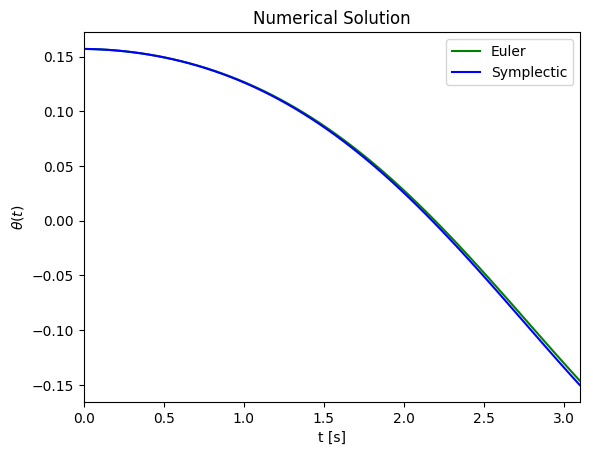

In [1080]:
# Solve and plot results

thetaSym,uSym = symplectic(t,dt,theta0,u0,order,params)
thetaEuler,uEuler = euler(t,dt,theta0,u0,params)

plt.plot(t,thetaEuler,label="Euler",color="g")
plt.plot(t,thetaSym,label="Symplectic",color="b")
plt.xlabel('t [s]')
plt.ylabel(r'$\theta(t)$')
plt.xlim(0,dt*nt)
plt.legend()
plt.title("Numerical Solution")
plt.show()

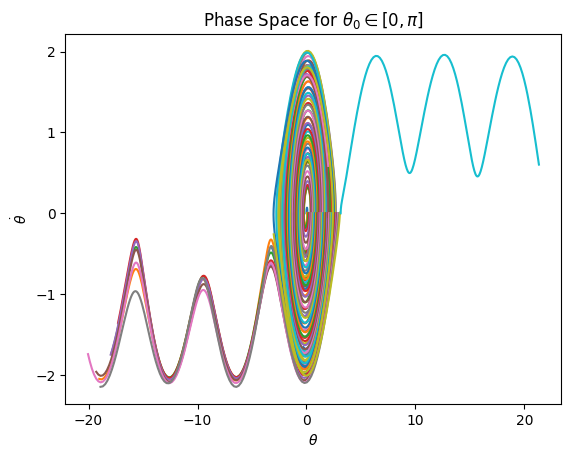

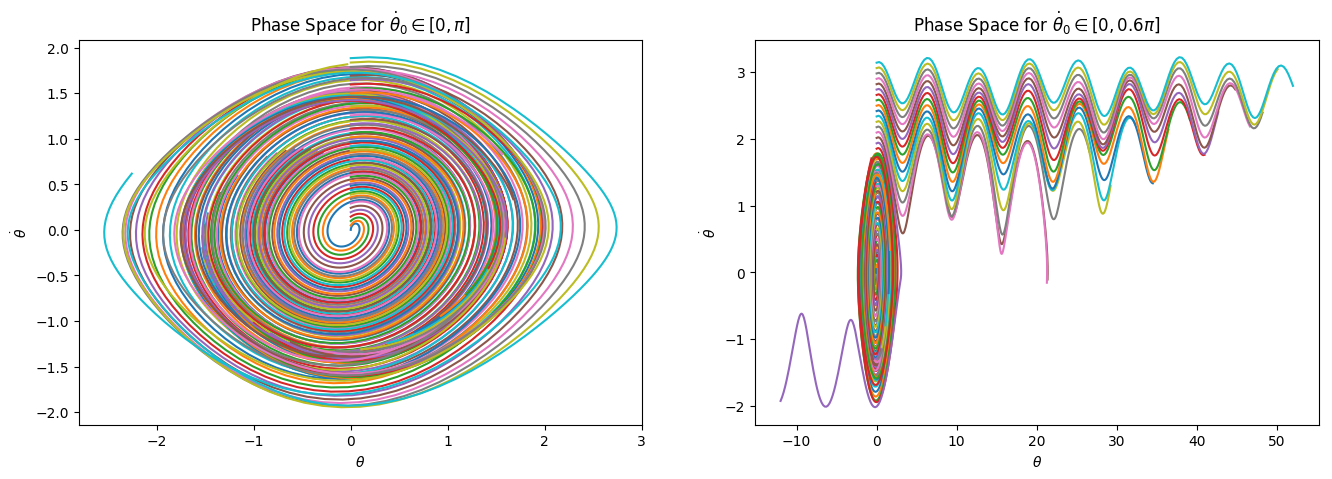

In [1050]:
# Phase space plots
nth = 40 # number of values to run

# Vary theta
theta0s = np.linspace(0,1,nth)*np.pi
u0s = np.zeros(nth)
for i in range(nth):
    thetas,us = symplectic(t,dt,theta0s[i],u0s[i],order,params)
    plt.plot(thetas,us)

plt.xlabel(r'$\theta$')
plt.ylabel(r'$\dot{\theta}$')
plt.title(r'Phase Space for $\theta_{0} \in [0,\pi]$')
#plt.savefig("figures/phaseSpace.png")
plt.show()


# Vary theta_dot
fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

theta0s1 = np.zeros(nth); theta0s2 = np.zeros(nth)
u0s1 = np.linspace(0,0.6,nth)*np.pi; u0s2 = np.linspace(0,1,nth)*np.pi

for i in range(nth):
    thetas1,us1 = symplectic(t,dt,theta0s1[i],u0s1[i],order,params)
    thetas2,us2 = symplectic(t,dt,theta0s2[i],u0s2[i],order,params)
    ax1.plot(thetas1,us1)
    ax2.plot(thetas2,us2)
    

ax1.set_xlabel(r'$\theta$')
ax1.set_ylabel(r'$\dot{\theta}$')
ax1.set_title(r'Phase Space for $\dot{\theta}_{0} \in [0,\pi]$')

ax2.set_xlabel(r'$\theta$')
ax2.set_ylabel(r'$\dot{\theta}$')
ax2.set_title(r'Phase Space for $\dot{\theta}_{0} \in [0,0.6\pi]$')
#plt.savefig("figures/phaseSpaceDot.png")
plt.show()
    
#plt.savefig("figures/phaseSpaceDot2.png")
plt.show()

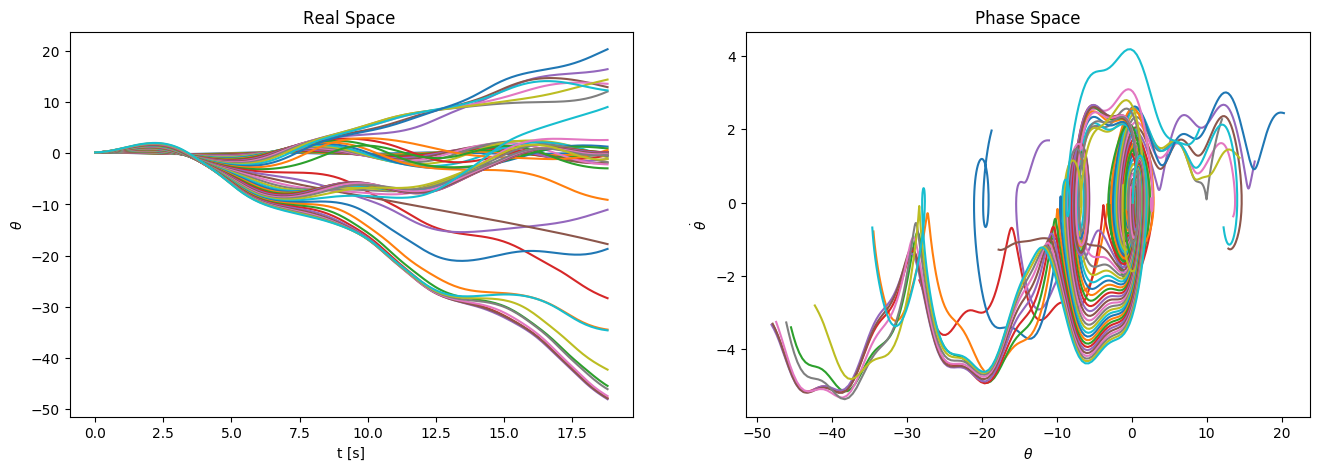

In [1052]:
# Effect of varying gamma

fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

gNum = 50 # number of gamma values
gMax = 2 # maximum gamma value
gammas = np.linspace(0,gMax,gNum)

# Plot results for all gammas
for i in gammas:
    params["gamma"] = i
    theta,u = symplectic(t,dt,theta0,u0,order,params)
    ax1.plot(t,theta)
    ax2.plot(theta,u)


ax1.set_title("Real Space ")
ax2.set_title("Phase Space")
ax1.set_xlabel("t [s]"); ax1.set_ylabel(r"$\theta$")
ax2.set_xlabel(r"$\theta$"); ax2.set_ylabel(r"$\dot{\theta}$")

plt.show()

In [1073]:
# Identifying (theta0,gamma) pairs for which motion diverges

thMax = np.pi; thNum = 70;
gMax = 4; gNum = 70;
theta0s = np.linspace(0,thMax,thNum)
gammas = np.linspace(0,gMax,gNum)

div = np.zeros([0,3])
progress = 0

for th in theta0s:
    progress += 1
    print(int(100*progress/thNum),end="% \r") #display progress of calculations
    
    for ga in gammas:
        params["gamma"] = ga
        theta,u = symplectic(t,dt,th,u0,order,params)
        if (np.abs(theta[-1]) > np.pi):
            div = np.concatenate((div,np.array([[th,ga,theta[-1]]])))

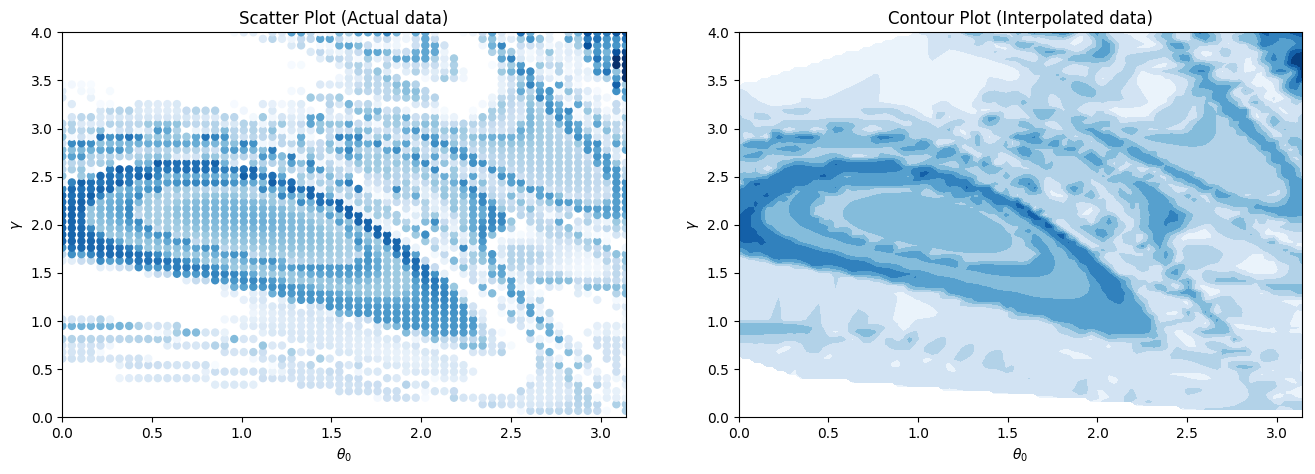

In [1072]:
# Plotting results

fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121,xlim=[0,thMax],ylim=[0,gMax])
ax2 = fig.add_subplot(122,xlim=[0,thMax],ylim=[0,gMax])
colormap = plt.cm.Blues

# Colormapped scatter plot
col = np.abs(div[:,2]) # define colors
ax1.scatter(div[:,0],div[:,1],c=col,cmap=colormap,s=25)

# Colormapped contour plot
X = np.linspace(0,thMax,100); Y = np.linspace(0,gMax,100)
Z = plt.mlab.griddata(div[:,0],div[:,1],np.abs(div[:,2]),X,Y,interp='linear')
X,Y = np.meshgrid(X,Y)
ax2.contourf(X,Y,Z,cmap=colormap)

ax1.set_title("Scatter Plot (Actual data)")
ax1.set_xlabel(r"$\theta_{0}$")
ax1.set_ylabel(r"$\gamma$")

ax2.set_title("Contour Plot (Interpolated data)")
ax2.set_xlabel(r"$\theta_{0}$")
ax2.set_ylabel(r"$\gamma$")

plt.savefig("figures/diverge2.png")

plt.show()
# Color corresponds to value of theta at final time

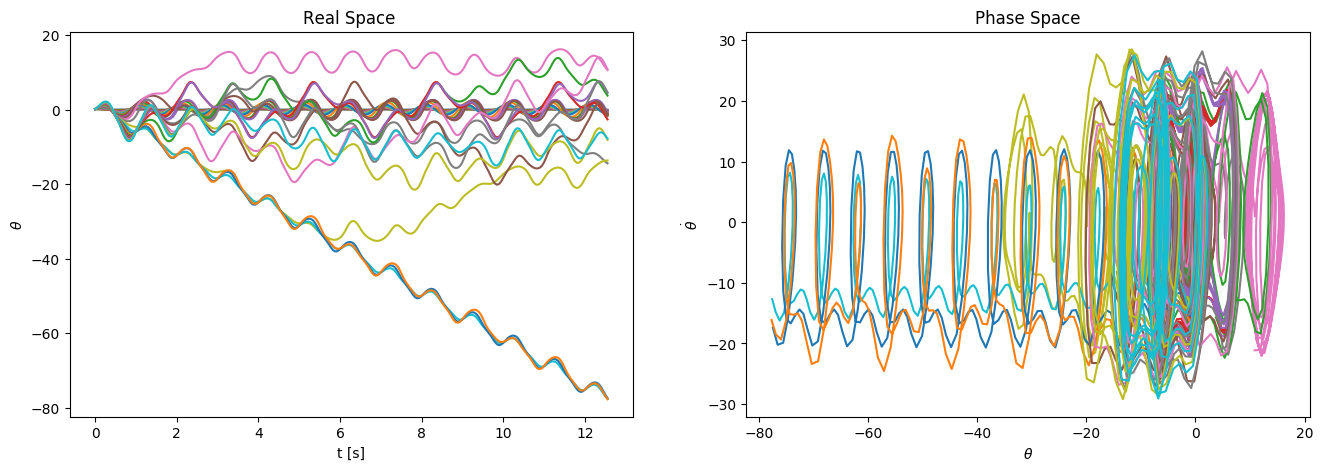

In [1182]:
# Damping, 

params = {"k":3*np.pi,"gamma":0,"w":2*np.pi,"B":0.75*np.pi}
gammas = np.linspace(0,2,30)

fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# Plot results for all gammas
for ga in gammas:
    params["gamma"] = ga
    theta,u = symplectic(t,dt,theta0,u0,order,params)
    ax1.plot(t,theta)
    ax2.plot(theta,u)

ax1.set_title("Real Space ")
ax2.set_title("Phase Space")
ax1.set_xlabel("t [s]"); ax1.set_ylabel(r"$\theta$")
ax2.set_xlabel(r"$\theta$"); ax2.set_ylabel(r"$\dot{\theta}$")

plt.show()

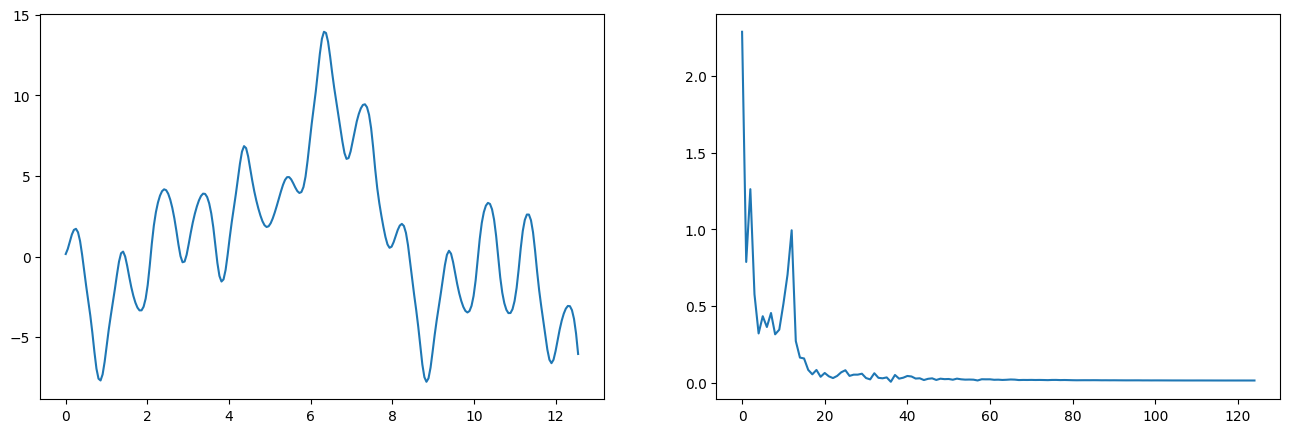

[ 1.12293137  2.29008517  0.7875092   1.26257793  0.57637458  0.32066454
  0.43315728  0.36283997  0.45415434  0.31504007  0.3455113   0.51370245
  0.70487165  0.99431722  0.27102105  0.16318111  0.15744264  0.08295302
  0.05393166  0.08247908  0.0377218   0.06268431  0.04080652  0.0294057
  0.04332984  0.06729625  0.08058673  0.04364495  0.05169682  0.05184848
  0.0579073   0.02957972  0.02084107  0.06106059  0.03103525  0.02795694
  0.03368626  0.00523988  0.04969222  0.02568441  0.03183332  0.04310625
  0.03980483  0.02631312  0.02799536  0.01666263  0.02454505  0.02769548
  0.01718145  0.02542128  0.0224113   0.02339872  0.018684    0.02568869
  0.02140544  0.01926263  0.01981188  0.01898648  0.01379816  0.02170775
  0.02121754  0.02133776  0.01826505  0.01896647  0.01719926  0.0183535
  0.02018978  0.01926709  0.01647382  0.01729504  0.01697069  0.01748704
  0.01686461  0.01722824  0.01669829  0.01603536  0.01720927  0.01737099
  0.01629183  0.0168274   0.01619916  0.01549861  0.0

In [1189]:
# Fourier analysis

params["gamma"] = 1.7
theta,u = symplectic(t,dt,theta0,u0,order,params)

fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

thetaFT = np.fft.fft(theta)/theta.size
#thetaFT = np.fft.fft(theta)/theta.size
freq = np.fft.fftfreq(nt,dt)

ax1.plot(t,theta)
ax2.plot(np.abs(thetaFT[1:int((nt+1)/2)]))
#ax1.set_axes([0,time,np.min(theta),np.max(theta)])
#ax2.set_axes([0,(nt+1)/2,0,np.max(thetaFT)])
plt.show()

print(np.abs(thetaFT))